In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [4]:
mnist.data.shape

(70000, 784)

In [5]:
X ,y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [6]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

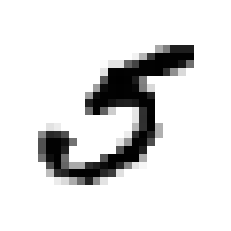

In [7]:
# plot the first image
plt.imshow(some_digit_image, cmap='binary', interpolation='nearest')
plt.axis('off')
plt.show()

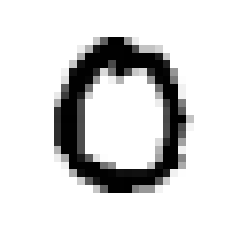

In [8]:
plt.imshow(X[3600].reshape(28,28), cmap='binary', interpolation='nearest')
plt.axis('off')
plt.show()


In [9]:
# splitting the  data into train and  test set
X_train , X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
# shuffling the dataset
shuffle_index = np.random.permutation(60000)
x_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Training a binary classifier

In [11]:
# creating a 5-detector 
y_train_5 = (y_train == 5)
y_test_5 =  (y_test ==5)

In [12]:
# flattening the dataset from a 3-D to a 2-D 
# X_train_2d = X_train.reshape(X_train.shape[0], -1)
# X_test_2d = X_test.reshape(X_test.shape[0], -1)

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=66)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=66)

Stochastic Gradient Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class. This clas‐ sifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning)

In [14]:
some_digit = X_train[36000]
sgd_clf.predict([some_digit])

array([False])

In [15]:
some_5_digit = X_train[89]
sgd_clf.predict([some_5_digit])

array([False])

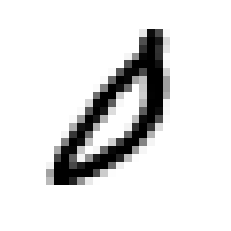

In [16]:
# plotting the image
plt.imshow(X_train[89].reshape(28,28), cmap='binary', interpolation='nearest')
plt.axis('off')
plt.show()

### Implementing the cross-validation from scratch

In [ ]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5): 
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # prints 0.9502, 0.96565 and 0.9649

In [19]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.72005, 0.8923 , 0.8183 ])

In [20]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.zeros((len(X), 1),dtype=bool)

In [21]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9122 , 0.90775, 0.909  ])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time. Beats Nostradamus.
This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).

In [22]:
# confusion matrix
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the <b style="color:blue;font-size:26px;"> predictions</b> made on each test fold. This means that you get a clean prediction for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training).

[[47967  6612]
 [ 4775   646]]


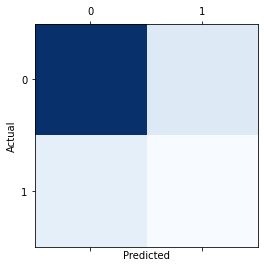

In [23]:
from sklearn.metrics import confusion_matrix

# confusion matrix with the actual values
print(confusion_matrix(y_train_5, y_train_pred))

plt.matshow(confusion_matrix(y_train_5, y_train_pred), cmap=plt.cm.Blues, interpolation='nearest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Each row in a confusion matrix represents an actual class while the columns represent the predicted columns

In [26]:
from sklearn.metrics import precision_score, recall_score ,f1_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))
print(f1_score(y_train_5,y_train_pred))


0.08900523560209424
0.11916620549714074
0.10190078081867655


In [28]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-2150.71456188])

In [29]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [30]:
y_scores =  cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

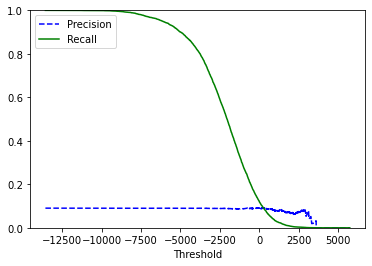

In [31]:
from sklearn.metrics import  precision_recall_curve

precisions, recalls ,thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

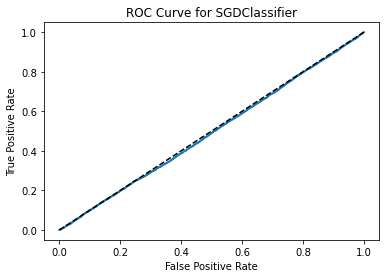

The AUC of the SGDClassifier is:  0.4932467338096509


In [37]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.title('ROC Curve for SGDClassifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

print("The AUC of the SGDClassifier is: ",roc_auc_score(y_train_5, y_scores))

This is no better than random guessing 

In [38]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')


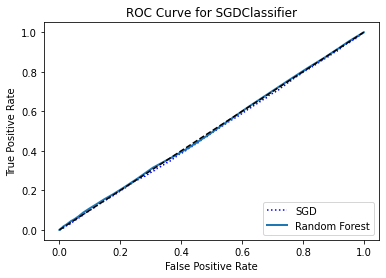

The AUC of the RandomForestClassifier is:  0.5014026434924346


In [40]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

print("The AUC of the RandomForestClassifier is: ",roc_auc_score(y_train_5, y_scores_forest))

## Multiclass Classification

Scikit-Learn detects when you try to use a binary classification algorithm for a multi‐ class classification task, and it automatically runs OvA (except for SVM classifiers for which it uses OvO)

In [41]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=int8)

In [42]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-2305.31338062, -3359.16221809,  -875.99485027,   -94.55569546,
         -798.09671184, -1636.39168527, -2480.09211061, -1476.59366615,
        -1430.82617561, -1757.02112879]])

In [44]:
np.argmax(some_digit_scores)
print(sgd_clf.classes_)
#print(sgd_clf.classes[5])

[0 1 2 3 4 5 6 7 8 9]


If you want to force ScikitLearn to use one-versus-one or one-versus-all, you can use the OneVsOneClassifier or OneVsRestClassifier classes. Simply create an instance and pass a binary classifier to its constructor.

In [45]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=66))
ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit]))
print(len(ovo_clf.estimators_))

[2]
45


In [46]:
# training a random forest 
forest_clf.fit(X_train, y_train)

print(forest_clf.predict([some_digit]))
print(forest_clf.predict_proba([some_digit]))

[1]
[[0.03 0.64 0.05 0.06 0.04 0.01 0.06 0.07 0.03 0.01]]


In [47]:
cross_val_score(sgd_clf, X_train, y_train, cv=4, scoring='accuracy')

array([0.1       , 0.0944    , 0.09886667, 0.10173333])

In [48]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.0994 , 0.09895, 0.1008 ])

In [49]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[558, 669, 380, 455, 692, 726, 573, 614, 481, 775],
       [665, 744, 428, 461, 787, 831, 677, 640, 596, 913],
       [593, 659, 363, 390, 787, 712, 603, 590, 503, 758],
       [599, 609, 396, 422, 755, 767, 626, 611, 531, 815],
       [501, 621, 443, 386, 737, 748, 570, 595, 483, 758],
       [526, 564, 366, 370, 667, 647, 580, 518, 457, 726],
       [552, 662, 378, 419, 704, 750, 597, 552, 526, 778],
       [636, 676, 437, 430, 779, 777, 626, 606, 514, 784],
       [555, 639, 362, 448, 715, 698, 584, 578, 504, 768],
       [560, 665, 408, 408, 732, 673, 597, 582, 519, 805]])

## Multilabel Classification

In [50]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

array([[False,  True]])

In [51]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.36218134560530973

Multilabel classification is simply a generalization of multiclass classification where each label can be multiclass (i.e., it can have more than two possible values).

## Multioutput Classification

In [52]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [53]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation='nearest')
    plt.axis('off')

In [ ]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
#save_fig("noisy_digit_example_plot")
plt.show()

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
#save_fig("cleaned_digit_example_plot")